In [1]:
import numpy as np
from numpy import ravel
import pandas as pd
import glob 
import scipy
import matplotlib.pyplot as plt
from scipy import signal
import natsort 

In [2]:
path = 'G:/SOH_estimation/Published/'
charge05 = natsort.natsorted(glob.glob(path+'charge05/*.csv'),reverse=False)
charge06 = natsort.natsorted(glob.glob(path+'charge06/*.csv'),reverse=False)
charge07 = natsort.natsorted(glob.glob(path+'charge07/*.csv'),reverse=False)
charge18 = natsort.natsorted(glob.glob(path+'charge18/*.csv'),reverse=False)
charge53 = natsort.natsorted(glob.glob(path+'charge53/*.csv'),reverse=False)
charge54 = natsort.natsorted(glob.glob(path+'charge54/*.csv'),reverse=False)
charge55 = natsort.natsorted(glob.glob(path+'charge55/*.csv'),reverse=False)
charge56 = natsort.natsorted(glob.glob(path+'charge56/*.csv'),reverse=False)
discharge05 = natsort.natsorted(glob.glob(path+'discharge05/*.csv'),reverse=False)
discharge06 = natsort.natsorted(glob.glob(path+'discharge06/*.csv'),reverse=False)
discharge07 = natsort.natsorted(glob.glob(path+'discharge07/*.csv'),reverse=False)
discharge18 = natsort.natsorted(glob.glob(path+'discharge18/*.csv'),reverse=False)
discharge53 = natsort.natsorted(glob.glob(path+'discharge53/*.csv'),reverse=False)
discharge54 = natsort.natsorted(glob.glob(path+'discharge54/*.csv'),reverse=False)
discharge55 = natsort.natsorted(glob.glob(path+'discharge55/*.csv'),reverse=False)
discharge56 = natsort.natsorted(glob.glob(path+'discharge56/*.csv'),reverse=False)


In [3]:
def resample(data):
    downsampled_data = scipy.signal.resample(data, 20, axis=0)
    return downsampled_data

def scale(x, max_arr, min_arr, out_range=(-1.0, 1.0)):
    emp = np.empty(x.shape)
    for i in range(x.shape[1]):
        domain = max_arr[i], min_arr[i]
        y = (x[:,i] - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
        emp[:,i] = y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2
    return emp
    
def check_nan(data, y):
    data = np.array(data, dtype=float)
    y = np.array(y, dtype=float)
    not_null = ~np.isnan(data).any(axis=2)
    data1 = data[not_null,:]
    data1 = np.reshape(data1, (int(data1.shape[0]/20),20,12))
    not_null = [False if False in i else True for i in ~np.isnan(data).any(axis=2)]
    y1 = y[not_null]
    return data1, y1


def dataReader(charge_path, discharge_path):
    data_n = np.empty((1,20, 12), dtype=object)
    y_n = np.empty((1,1), dtype=object)
    max_arr = [4.37333112e+00, 1.66690126e+00, 3.14417117e+01, 1.65778686e+00, 5.62910436e+00, 1.12503468e+04, 4.06791213e+00, 3.41170830e-01, 4.31502666e+01, 2.27654755e+00, 3.34093685e+00, 3.84572280e+03]
    min_arr = [ 3.58278925e+00, -1.42228262e-01,  3.87019685e+00, -1.40117317e-01, -8.09534168e-01, -8.08275532e+02,  1.98507963e+00, -2.29147162e+00, 3.60645170e+00, -2.26602563e+00, -4.38033642e-01, -1.37994647e+02]

    for i in range(len(charge_path)):
            
            load_charge = pd.read_csv(charge_path[i],header=None)
            #load_charge = load_charge[load_charge.iloc[:,1]>0]
            charge_data = resample(load_charge)
            charge_data = scale(charge_data, max_arr[:6],min_arr[:6])
            charge_data = np.reshape(charge_data, (1,20,6), order = 'F')
            
            load_discharge = pd.read_csv(discharge_path[i], header=None)
            #load_discharge = load_discharge[load_discharge.iloc[:,1]>0]
            discharge_data = load_discharge.iloc[:,0:6]
            discharge_data = resample(discharge_data)
            discharge_data = scale(discharge_data, max_arr[6:],min_arr[6:])
            #print(discharge_data.shape)
            discharge_data = np.reshape(discharge_data, (1,20,6), order = 'F')
            
            processed_data = np.concatenate((charge_data, discharge_data), axis=2)
        
            data_n = np.concatenate((data_n, processed_data), axis=0)
            
            y = np.array([load_discharge.iloc[0,6]])

            y = np.reshape(y, (1,1))
            y_n = np.concatenate((y_n, y), axis=0)

    return check_nan(data_n[1:], y_n[1:])

In [4]:
data05, y05 = dataReader(charge05, discharge05)
data06, y06 = dataReader(charge06, discharge06)
data07, y07 = dataReader(charge07, discharge07)
data18, y18 = dataReader(charge18, discharge18)
data53, y53 = dataReader(charge53, discharge53)
data54, y54 = dataReader(charge54, discharge54)
data55, y55 = dataReader(charge55, discharge55)
data56, y56 = dataReader(charge56, discharge56)

data = np.concatenate((data05,data06,data07,data18,data53,data54,data55,data56),axis=0)
y = np.concatenate((y05,y06,y07,y18,y53,y54,y55,y56), axis=0)

In [5]:
data = np.array(data, dtype=float)
y = np.array(y, dtype=float)
print(data.shape)
print(y.shape)

(996, 20, 12)
(996, 1)


In [6]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error as mse
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, shuffle=True)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train_dnn = np.reshape(X_train, (X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test_dnn = np.reshape(X_test, (X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
print(X_train_dnn.shape)
print(X_test_dnn.shape)

(796, 20, 12)
(796, 1)
(200, 20, 12)
(200, 1)
(796, 240)
(200, 240)


In [8]:
#DNN MODEL

model_dnn = Sequential()
model_dnn.add(Dense(256, activation='relu', input_shape=(240,),kernel_initializer='random_uniform'))
#model_dnn.add(Dense(256, activation='relu',kernel_initializer='random_uniform'))
model_dnn.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
#model_dnn.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
model_dnn.add(Dense(32, activation='relu',kernel_initializer='random_uniform'))
model_dnn.add(Dense(16, activation='relu',kernel_initializer='random_uniform'))
model_dnn.add(Dense(1, kernel_initializer='random_uniform'))

In [9]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_dnn.compile(loss=rmse, optimizer=optimizer, metrics=[rmse])
#model_dnn.fit(X_train_dnn, y_train, epochs=1000)

Epoch 1/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0083 - rmse: 0.0083
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0081 - rmse: 0.0081
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0080 - rmse: 0.0080
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0081 - rmse: 0.0082
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0082 - rmse: 0.0082
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0081 - rmse: 0.0081
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0083 - rmse: 0.0083
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0084 - rmse: 0.0084
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0080 - rmse: 0.0080
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0081 - rmse: 0.0081
Epoch 11/100
25/25 [=============================

In [10]:
#model_dnn.save_weights('dnn_weights.h5')
model_dnn.load_weights('dnn_weights.h5')

In [11]:
test_data = np.array(data05, dtype=float)
test_labels = np.array(y05, dtype=float)
predictions_dnn = model_dnn.predict(np.reshape(test_data, (test_data.shape[0],test_data.shape[1]*test_data.shape[2])))

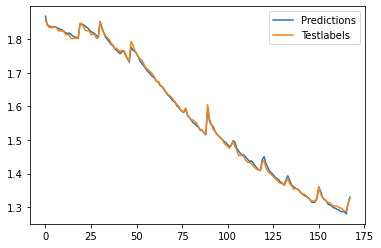

In [12]:
from matplotlib import pyplot


pyplot.plot(predictions_dnn)

pyplot.plot(test_labels)
pyplot.legend(['Predictions', 'Testlabels'])
pyplot.savefig("dnn_img")

In [13]:
#CNN MODEL
model_cnn = Sequential()
                     
model_cnn.add(Conv1D(filters=8, kernel_size=3,padding="same", activation="relu", input_shape=[20, 12]))

model_cnn.add(Flatten())

model_cnn.add(Dense(64, activation='tanh', kernel_initializer='random_uniform'))

model_cnn.add(Dense(32,activation='relu', kernel_initializer='random_uniform'))

model_cnn.add(Dense(1, kernel_initializer='random_uniform'))

In [36]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model_cnn.compile(loss=rmse,
              optimizer=optimizer,
              metrics=[rmse])

In [ ]:
#history = model_cnn.fit(X_train, y_train, epochs=1000)

In [ ]:
#model_cnn.save_weights('cnn_weights.h5')

In [14]:
model_cnn.load_weights('cnn_weights.h5')

In [15]:
predictions_cnn = model_cnn.predict(test_data)

In [16]:
#SimpleRNN MODEL

model_simpleRNN = Sequential()
model_simpleRNN.add(tf.keras.layers.Masking(input_shape = [20, 12]))    

model_simpleRNN.add(SimpleRNN(32, activation='relu' ,kernel_initializer='random_uniform' ))

#model.add(Dense(128, activation='tanh', kernel_initializer='random_uniform'))

model_simpleRNN.add(Dense(16,activation='relu', kernel_initializer='random_uniform'))
model_simpleRNN.add(Dense(1, kernel_initializer='random_uniform'))
model_simpleRNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 20, 12)            0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1440      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________


In [11]:
#NO NEED TO RUN
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model_simpleRNN.compile(loss=rmse, optimizer=optimizer, metrics=[rmse])

In [88]:
#NO NEED TO RUN
history = model_simpleRNN.fit(X_train, y_train, epochs=20)

Train on 796 samples
Epoch 1/20
796/796 [==============================] - 0s 356us/sample - loss: 0.0088 - rmse: 0.0088
Epoch 2/20
796/796 [==============================] - 0s 283us/sample - loss: 0.0065 - rmse: 0.0065
Epoch 3/20
796/796 [==============================] - 0s 278us/sample - loss: 0.0069 - rmse: 0.0069
Epoch 4/20
796/796 [==============================] - 0s 269us/sample - loss: 0.0067 - rmse: 0.0067
Epoch 5/20
796/796 [==============================] - 0s 279us/sample - loss: 0.0070 - rmse: 0.0070
Epoch 6/20
796/796 [==============================] - 0s 272us/sample - loss: 0.0069 - rmse: 0.0069
Epoch 7/20
796/796 [==============================] - 0s 256us/sample - loss: 0.0068 - rmse: 0.0068
Epoch 8/20
796/796 [==============================] - 0s 270us/sample - loss: 0.0067 - rmse: 0.0067
Epoch 9/20
796/796 [==============================] - 0s 273us/sample - loss: 0.0074 - rmse: 0.0074
Epoch 10/20
796/796 [==============================] - 0s 268us/sample - loss: 

In [82]:
#NO NEED TO RUN
model_simpleRNN.save_weights('simpleRNN_weights.h5')

In [17]:
model_simpleRNN.load_weights('simpleRNN_weights.h5')

In [18]:
predictions_rnn = model_simpleRNN.predict(test_data)

(168, 1)
(168, 1)


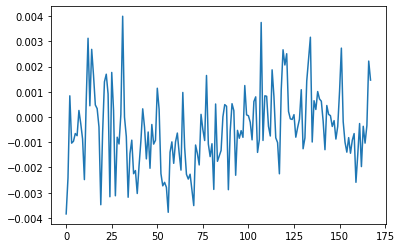

In [19]:
print(predictions_rnn.shape)
print(test_labels.shape)
error_rnn = np.subtract(predictions_rnn, test_labels)
per_error_rnn = error_rnn/max(predictions_rnn)

plt.plot(per_error_rnn)

#pyplot.plot(test_labels)
plt.show()

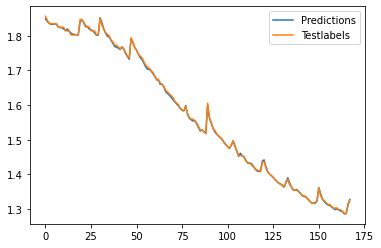

In [20]:
from matplotlib import pyplot


pyplot.plot(predictions_rnn)

pyplot.plot(test_labels)
pyplot.legend(['Predictions', 'Testlabels'])
pyplot.savefig("wewe")

In [21]:
#GRU MODEL

model_gru = Sequential()
model_gru.add(tf.keras.layers.Masking(input_shape = [20, 12]))    

model_gru.add(GRU(32 ,kernel_initializer='random_uniform' ))

model_gru.add(Dense(16,activation='relu', kernel_initializer='random_uniform'))
model_gru.add(Dense(1, kernel_initializer='random_uniform'))
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 20, 12)            0         
_________________________________________________________________
gru (GRU)                    (None, 32)                4416      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [115]:
#NO NEED TO RUN
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model_gru.compile(loss=rmse, optimizer=optimizer, metrics=[rmse])

In [116]:
#NO NEED TO RUN
history = model_gru.fit(X_train, y_train, epochs=20)

Train on 796 samples
Epoch 1/20
796/796 [==============================] - 0s 599us/sample - loss: 0.0067 - rmse: 0.0067
Epoch 2/20
796/796 [==============================] - 0s 526us/sample - loss: 0.0067 - rmse: 0.0067
Epoch 3/20
796/796 [==============================] - 0s 479us/sample - loss: 0.0067 - rmse: 0.0067
Epoch 4/20
796/796 [==============================] - 0s 486us/sample - loss: 0.0066 - rmse: 0.0066
Epoch 5/20
796/796 [==============================] - 0s 516us/sample - loss: 0.0067 - rmse: 0.0067
Epoch 6/20
796/796 [==============================] - 0s 507us/sample - loss: 0.0067 - rmse: 0.0067
Epoch 7/20
796/796 [==============================] - 0s 508us/sample - loss: 0.0067 - rmse: 0.0067
Epoch 8/20
796/796 [==============================] - 0s 535us/sample - loss: 0.0066 - rmse: 0.0066
Epoch 9/20
796/796 [==============================] - 0s 519us/sample - loss: 0.0066 - rmse: 0.0066
Epoch 10/20
796/796 [==============================] - 0s 472us/sample - loss: 

In [117]:
#NO NEED TO RUN
model_gru.save_weights('gru_weights.h5')

In [22]:
model_gru.load_weights('gru_weights.h5')

In [23]:
predictions_gru = model_gru.predict(test_data)

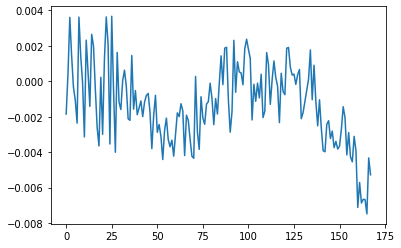

In [24]:
error_gru = np.subtract(predictions_gru, test_labels)
per_error_gru = error_gru/max(predictions_gru)

plt.plot(per_error_gru)
#pyplot.plot(per_error1)
plt.show()

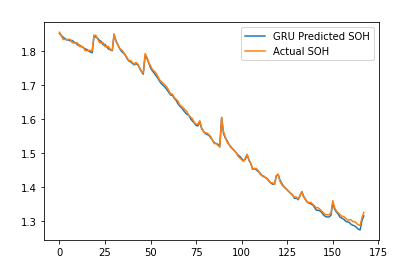

In [25]:
from matplotlib import pyplot

pyplot.plot(predictions_gru)
pyplot.plot(test_labels)
pyplot.xlabel('cycles', color='w')
pyplot.ylabel('%SOH', color='w')
pyplot.title('Battery #5', color='w')
pyplot.legend(['GRU Predicted SOH', 'Actual SOH'])
pyplot.savefig("gru_img.png")


In [26]:
#LSTM MODEL

model_lstm = Sequential()
model_lstm.add(tf.keras.layers.Masking(input_shape = [20, 12]))    

model_lstm.add(LSTM(32, activation='relu' ,kernel_initializer='random_uniform' ))

#model.add(Dense(128, activation='tanh', kernel_initializer='random_uniform'))

model_lstm.add(Dense(16,activation='relu', kernel_initializer='random_uniform'))
model_lstm.add(Dense(1, kernel_initializer='random_uniform'))
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 20, 12)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5760      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 6,305
Trainable params: 6,305
Non-trainable params: 0
_________________________________________________________________


In [152]:
#NO NEED TO RUN
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.Adam(learning_rate=3*1e-7)

model_lstm.compile(loss=rmse, optimizer=optimizer, metrics=[rmse])

In [153]:
#NO NEED TO RUN
history = model_lstm.fit(X_train, y_train, epochs=20)

Train on 796 samples
Epoch 1/20
796/796 [==============================] - 0s 601us/sample - loss: 0.0085 - rmse: 0.0085
Epoch 2/20
796/796 [==============================] - 0s 542us/sample - loss: 0.0084 - rmse: 0.0084
Epoch 3/20
796/796 [==============================] - 0s 503us/sample - loss: 0.0085 - rmse: 0.0085
Epoch 4/20
796/796 [==============================] - 0s 503us/sample - loss: 0.0085 - rmse: 0.0085
Epoch 5/20
796/796 [==============================] - 0s 507us/sample - loss: 0.0085 - rmse: 0.0085
Epoch 6/20
796/796 [==============================] - 0s 535us/sample - loss: 0.0085 - rmse: 0.0085
Epoch 7/20
796/796 [==============================] - 0s 547us/sample - loss: 0.0085 - rmse: 0.0085
Epoch 8/20
796/796 [==============================] - 0s 513us/sample - loss: 0.0085 - rmse: 0.0085
Epoch 9/20
796/796 [==============================] - 0s 536us/sample - loss: 0.0085 - rmse: 0.0085
Epoch 10/20
796/796 [==============================] - 0s 528us/sample - loss: 

In [154]:
#NO NEED TO RUN
model_lstm.save_weights('lstm_weights.h5')

In [27]:
model_lstm.load_weights('lstm_weights.h5')

In [28]:
predictions_lstm = model_lstm.predict(test_data)

In [29]:
test_data = np.array(data56, dtype=float)
test_labels = np.array(y56, dtype=float)

predictions_dnn = model_dnn.predict(np.reshape(test_data, (test_data.shape[0],test_data.shape[1]*test_data.shape[2])))

predictions_rnn = model_simpleRNN.predict(test_data)
predictions_gru = model_gru.predict(test_data)
predictions_lstm = model_lstm.predict(test_data)

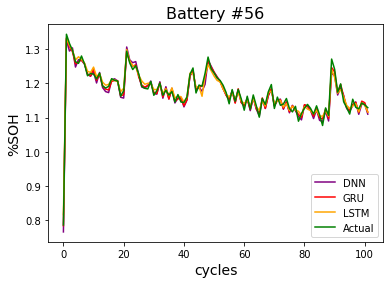

In [30]:
from matplotlib import pyplot
pyplot.plot(predictions_dnn, color='purple')
pyplot.plot(predictions_gru, color='r')
pyplot.plot(predictions_lstm, color='orange')
pyplot.plot(test_labels, color='g')
pyplot.xlabel('cycles', color='black', fontsize=14)
pyplot.ylabel('%SOH', color='black', fontsize=14)
pyplot.title('Battery #56', color='black', fontsize=16)
pyplot.legend(['DNN','GRU','LSTM', 'Actual'])
pyplot.savefig('w0iiw0.png')

In [31]:
def rmse_error(data, y):
    sim_rnn = model_simpleRNN.predict(data)
    dnn_d = model_dnn.predict(np.reshape(data, (data.shape[0],data.shape[1]*data.shape[2])))
    lstm_d = model_lstm.predict(data)
    gru_d = model_gru.predict(data)
    cnn_d = model_cnn.predict(data)
    err = np.array((rmse(sim_rnn, y)))
    err = np.append(err,np.array((rmse(gru_d, y))))
    err = np.append(err,np.array((rmse(lstm_d, y))))
    err = np.append(err,np.array((rmse(dnn_d, y))))
    err = np.append(err,np.array((rmse(cnn_d, y))))
    err_lst = err.tolist()
    dict = {'DNN':float("{:.3f}".format(err_lst[3])), 'CNN':float("{:.3f}".format(err_lst[4])), 'simpleRNN':float("{:.3f}".format(err_lst[0])), 'GRU':float("{:.3f}".format(err_lst[1])), 'LSTM':float("{:.3f}".format(err_lst[2]))}
    return dict


In [32]:
dict = {}
dict['cell05']=rmse_error(np.array(data05, dtype=float),np.array(y05, dtype=float))
dict['cell06']=rmse_error(np.array(data06, dtype=float),np.array(y06, dtype=float))
dict['cell07']=rmse_error(np.array(data07, dtype=float),np.array(y07, dtype=float))
dict['cell18']=rmse_error(np.array(data18, dtype=float),np.array(y18, dtype=float))
dict['cell53']=rmse_error(np.array(data53, dtype=float),np.array(y53, dtype=float))
dict['cell54']=rmse_error(np.array(data54, dtype=float),np.array(y54, dtype=float))
dict['cell55']=rmse_error(np.array(data55, dtype=float),np.array(y55, dtype=float))
dict['cell56']=rmse_error(np.array(data56, dtype=float),np.array(y56, dtype=float))
print(dict)


import pickle

a_file = open("data.pkl", "wb")
pickle.dump(dict, a_file)
a_file.close()

{'cell05': {'DNN': 0.006, 'CNN': 0.004, 'simpleRNN': 0.003, 'GRU': 0.005, 'LSTM': 0.007}, 'cell06': {'DNN': 0.007, 'CNN': 0.004, 'simpleRNN': 0.005, 'GRU': 0.005, 'LSTM': 0.007}, 'cell07': {'DNN': 0.006, 'CNN': 0.003, 'simpleRNN': 0.003, 'GRU': 0.004, 'LSTM': 0.006}, 'cell18': {'DNN': 0.008, 'CNN': 0.004, 'simpleRNN': 0.004, 'GRU': 0.003, 'LSTM': 0.006}, 'cell53': {'DNN': 0.011, 'CNN': 0.008, 'simpleRNN': 0.011, 'GRU': 0.013, 'LSTM': 0.015}, 'cell54': {'DNN': 0.013, 'CNN': 0.006, 'simpleRNN': 0.009, 'GRU': 0.01, 'LSTM': 0.011}, 'cell55': {'DNN': 0.008, 'CNN': 0.007, 'simpleRNN': 0.01, 'GRU': 0.008, 'LSTM': 0.008}, 'cell56': {'DNN': 0.012, 'CNN': 0.006, 'simpleRNN': 0.01, 'GRU': 0.009, 'LSTM': 0.012}}


In [38]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def r_square(y_true, y_pred):
    sse = K.sum(K.square(y_true-y_pred))
    tss = K.sum(K.square(y_true - K.sum(y_true)/len(y_true)))
    return 1-(sse/tss)

In [34]:
def mae_error(data, y):
    sim_rnn = model_simpleRNN.predict(data)
    dnn_d = model_dnn.predict(np.reshape(data, (data.shape[0],data.shape[1]*data.shape[2])))
    lstm_d = model_lstm.predict(data)
    gru_d = model_gru.predict(data)
    cnn_d = model_cnn.predict(data)
    err = np.array((mae(sim_rnn, y)))
    err = np.append(err,np.array((mae(gru_d, y))))
    err = np.append(err,np.array((mae(lstm_d, y))))
    err = np.append(err,np.array((mae(dnn_d, y))))
    err = np.append(err,np.array((mae(cnn_d, y))))
    err_lst = err.tolist()
    dict = {'DNN':float("{:.3f}".format(err_lst[3])), 'CNN':float("{:.3f}".format(err_lst[4])), 'simpleRNN':float("{:.3f}".format(err_lst[0])), 'GRU':float("{:.3f}".format(err_lst[1])), 'LSTM':float("{:.3f}".format(err_lst[2]))}
    return dict

In [35]:
dict = {}
dict['cell05']=mae_error(np.array(data05, dtype=float),np.array(y05, dtype=float))
dict['cell06']=mae_error(np.array(data06, dtype=float),np.array(y06, dtype=float))
dict['cell07']=mae_error(np.array(data07, dtype=float),np.array(y07, dtype=float))
dict['cell18']=mae_error(np.array(data18, dtype=float),np.array(y18, dtype=float))
dict['cell53']=mae_error(np.array(data53, dtype=float),np.array(y53, dtype=float))
dict['cell54']=mae_error(np.array(data54, dtype=float),np.array(y54, dtype=float))
dict['cell55']=mae_error(np.array(data55, dtype=float),np.array(y55, dtype=float))
dict['cell56']=mae_error(np.array(data56, dtype=float),np.array(y56, dtype=float))
print(dict)


import pickle

a_file = open("data.pkl", "wb")
pickle.dump(dict, a_file)
a_file.close()

{'cell05': {'DNN': 0.004, 'CNN': 0.003, 'simpleRNN': 0.002, 'GRU': 0.004, 'LSTM': 0.005}, 'cell06': {'DNN': 0.005, 'CNN': 0.003, 'simpleRNN': 0.003, 'GRU': 0.004, 'LSTM': 0.005}, 'cell07': {'DNN': 0.004, 'CNN': 0.002, 'simpleRNN': 0.003, 'GRU': 0.003, 'LSTM': 0.004}, 'cell18': {'DNN': 0.006, 'CNN': 0.003, 'simpleRNN': 0.003, 'GRU': 0.003, 'LSTM': 0.004}, 'cell53': {'DNN': 0.009, 'CNN': 0.006, 'simpleRNN': 0.009, 'GRU': 0.01, 'LSTM': 0.013}, 'cell54': {'DNN': 0.009, 'CNN': 0.005, 'simpleRNN': 0.007, 'GRU': 0.007, 'LSTM': 0.008}, 'cell55': {'DNN': 0.006, 'CNN': 0.005, 'simpleRNN': 0.006, 'GRU': 0.006, 'LSTM': 0.006}, 'cell56': {'DNN': 0.01, 'CNN': 0.005, 'simpleRNN': 0.008, 'GRU': 0.008, 'LSTM': 0.01}}


In [39]:
def r_square_error(data, y):
    sim_rnn = model_simpleRNN.predict(data)
    dnn_d = model_dnn.predict(np.reshape(data, (data.shape[0],data.shape[1]*data.shape[2])))
    lstm_d = model_lstm.predict(data)
    gru_d = model_gru.predict(data)
    cnn_d = model_cnn.predict(data)
    err = np.array((r_square(sim_rnn, y)))
    err = np.append(err,np.array((r_square(gru_d, y))))
    err = np.append(err,np.array((r_square(lstm_d, y))))
    err = np.append(err,np.array((r_square(dnn_d, y))))
    err = np.append(err,np.array((r_square(cnn_d, y))))
    err_lst = err.tolist()
    dict = {'DNN':float("{:.3f}".format(err_lst[3])), 'CNN':float("{:.3f}".format(err_lst[4])), 'simpleRNN':float("{:.3f}".format(err_lst[0])), 'GRU':float("{:.3f}".format(err_lst[1])), 'LSTM':float("{:.3f}".format(err_lst[2]))}
    return dict

In [40]:
dict = {}
dict['cell05']=r_square_error(np.array(data05, dtype=float),np.array(y05, dtype=float))
dict['cell06']=r_square_error(np.array(data06, dtype=float),np.array(y06, dtype=float))
dict['cell07']=r_square_error(np.array(data07, dtype=float),np.array(y07, dtype=float))
dict['cell18']=r_square_error(np.array(data18, dtype=float),np.array(y18, dtype=float))
dict['cell53']=r_square_error(np.array(data53, dtype=float),np.array(y53, dtype=float))
dict['cell54']=r_square_error(np.array(data54, dtype=float),np.array(y54, dtype=float))
dict['cell55']=r_square_error(np.array(data55, dtype=float),np.array(y55, dtype=float))
dict['cell56']=r_square_error(np.array(data56, dtype=float),np.array(y56, dtype=float))
print(dict)


import pickle

a_file = open("data.pkl", "wb")
pickle.dump(dict, a_file)
a_file.close()

TypeError: x and y must have the same dtype, got tf.float64 != tf.float32